# Assignment

1. Implement your own AutoCorrelation Function (ACF) to estimate the fundamental frequency (f0) of a frame of audio.

2. Using the provided audio_blocking function, cut up a provided audio file into blocks, and apply your ACF function to each block.

## PART ONE: WRITE A FUNCTION: estimate_f0()

In your assigned pairs, walk through the steps necessary to use autocorrelation in order to estimate the pitch for the given audio frame. You will include your pseudo code steps as part of your submission along with the code.

[This can be a plain text long comment at the head of your script]

Ensure:

- that you window the frame to minimize discontinuities/spectral leakage

- normalize each frame's values by subtracting the mean of the frame

- that you return "np.nan" for any estimated max ACF value that is below the threshold for each frame

- return a single estimated pitch (or np.nan if the threshold is not met) per frame

*Hint on design: (test on a single frame of audio first!!!)*

Your function should return the estimated f0 for a given frame. I recommend using a list comprehension (a loop is fine if you are unfamiliar) to apply your function to each frame of the audio signal. Your output should be an array. (Note: use dtype = np.float64 when passing from a list to an array to preserve any np.nan values).



Your function should:


- Be called "estimate_f0"
- Have the following parameters WITH these names (do not change them!)
  - audio_frame (input = np.ndarray of samples) **not a filename!
  - sr (sample rate)
  - minfreq (the minimum frequency in Hz that the ACF function will "look for")
  - maxfreq (the maximum frequency in Hz that the ACF function will "look for")
  - threshold (the minimum ACF value below which there is not high reliability of pitched content)
- Return a single fundamental frequency estimate between your minfreq and maxfreq parameters OR np.nan for a given frame of audio


## PART TWO: APPLY YOUR FUNCTION TO EACH FRAME OF AUDIO USING OUR PRIOR FUNCTION (audio_blocking) & plot output

You should be able to obtain output using our previous audio_blocking function (please use the one found in our files for consistency) [https://gatech.instructure.com/courses/487902/files/folder/Reference_Code?preview=65294101]

such that:

data, times = audio_blocking(input_file)

returns the data variable, which is the array of audio blocks (i.e., each 'item' in data is one block of audio).

Using a list comprehension (or "for loop"), apply your estimate_f0 function to each frame in "data".
Plot the output and ensure that you have constrained your y_lim (frequency axis) to only show between 100 and 800 Hz.
Plot the f0 contours for the full audio files found in [https://gatech.instructure.com/courses/487902/files/folder/Audio/Assignments/Assignment1_f0acf]

Experiment with the following specifications for the plot to get the cleanest contour.

minfreq
maxfreq
frame_size
threshold
[A discussion post will be opened soon to aid in this choice]

## Your Final Submission

Please upload a zip file with:

a python script containing your pseudo code in plain text (comments) and your function code
the audio files we assigned for testing (assume your file is in the "." relative directory)**
and the image files (png or jpeg) showing your graph output.

In [12]:
!pip install scipy numpy matplotlib

In [13]:
import os
from scipy.io import wavfile
import numpy as np
import math

def block_audio(audio_input, sr=None, frame_size=2048, hop_ratio=0.5, pad=True):
    """
    Parameters
    ----------
    audio_input : np.ndarray or str
        Audio input. Should be able to come from either:
        - A NumPy array containing the audio signal.
        - A string path to an audio file (e.g., 'audio.wav').
    sr : int
        Sampling rate. Required if input is np.ndarray
    frame_size : int, optional
        Size of each frame in samples (default 2048).
    hop_ratio : float, optional
        Hop size as a ratio of the frame_size (default 0.5).
    pad : bool, optional
        If True (default), pads the signal with zeros to ensure all frames are the same length.
        If False, discards the last incomplete frame.
    Returns
    -------
    frames : np.ndarray
        2D array of shape (n_frames, frame_size).
    times : np.ndarray
        Array of start times (in seconds) for each frame.
    """

    # Handle input type
    if isinstance(audio_input, str):
        sr, audio_input = wavfile.read(audio_input)
    elif sr is None:
        raise ValueError("Must provide sampling rate with numpy array or file path as a string")

    # Convert to float in range [-1, 1)
    if audio_input.dtype == np.float32 or audio_input.dtype == np.float64:
        audio_input = audio_input
    else:
        # Determine bit depth and convert
        if audio_input.dtype == np.uint8:
            nbits = 8
        elif audio_input.dtype == np.int16:
            nbits = 16
        elif audio_input.dtype == np.int32:
            nbits = 32
        else:
            raise ValueError(f"Unsupported audio dtype: {audio_input.dtype}")

        audio_input = audio_input / float(2**(nbits - 1))

    # Convert to mono if stereo
    if len(audio_input.shape) > 1:
        audio_input = np.mean(audio_input, axis=1)

    # Calculate hop size as integer
    hop_size = int(hop_ratio * frame_size)

    # Calculate number of frames
    if pad:
        # Include all possible frames, padding the last one if necessary
        num_blocks = math.ceil((len(audio_input) - frame_size) / hop_size) + 1
        # Ensure we have at least one block even for very short audio
        num_blocks = max(1, num_blocks)
    else:
        # Only include complete frames
        num_blocks = max(0, (len(audio_input) - frame_size) // hop_size + 1)

    # Initialize output arrays
    audio_blocks = np.zeros([num_blocks, frame_size])

    # Compute time stamps
    times = (np.arange(0, num_blocks) * hop_size) / sr

    # Extract frames
    for n in range(num_blocks):
        i_start = n * hop_size
        i_stop = i_start + frame_size

        if i_stop <= len(audio_input):
            # Complete frame
            audio_blocks[n] = audio_input[i_start:i_stop]
        else:
            # Incomplete frame (only happens when pad=True)
            remaining_samples = len(audio_input) - i_start
            if remaining_samples > 0:
                audio_blocks[n, :remaining_samples] = audio_input[i_start:]
                # Rest of the frame is already zeros from initialization

    return audio_blocks, times

In [14]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
def estimate_f0(audio_frame, sr, minfreq=20, maxfreq=None, threshold=0.25):
  """
  Parameters
  ----------
  audio_frame : np.ndarray
      - A NumPy array containing the audio signal.
  sr : int
      Sampling rate. Required if input is np.ndarray
  minfreq : int, optional
      Minimum frequency in Hz that the ACF function will "look for"
  maxfreq : int, optional
      Hop size as a ratio of the frame_size (defaul sr/8).
  threshold : float, optional
      Minimum ACF value below which there is not high reliability of pitched content (default 0.25)
  Returns
  -------
  f0 : np.float64
      Fundamental frequency estimate between your minfreq and maxfreq parameters OR np.nan for a given frame of audio
  """
  # Handle inputs
  if maxfreq is None: maxfreq = sr / 8
  if maxfreq == 0: raise ValueError('Max Freq cannot be 0')
  if minfreq == 0: raise ValueError('Min Freq cannot be 0')
  # assign default output for later if no value is found
  f0 = np.nan
  # normalize from -1 to 1
  audio_frame = audio_frame / max(audio_frame)
  # apply periodic window function
  audio_frame = audio_frame * sig.windows.blackmanharris(len(audio_frame), sym=False)
  # subtract the mean
  sig.detrend(audio_frame, type='constant', overwrite_data=True)

  # convert frequencies to periods
  Tmax = 1/minfreq # lowest frequency becomes maximum period (in seconds)
  Tmin = 1/maxfreq # highest frequency becomes minimum period (in seconds)
  Nmax = int(np.ceil(Tmax * sr)) # seconds * samples/seconds = samples
  Nmin = int(np.floor(Tmin * sr))
  # calculate acf
  corr = np.correlate(audio_frame, audio_frame, mode='full')
  corr = corr[len(audio_frame)-1:]
  corr = corr / corr[0]


  corr = corr[Nmin:Nmax+1] # cut off periods above Nmax

  # find strongest peak
  peak_indeces, props = sig.find_peaks(corr, height=threshold, distance=Nmin)
  if len(peak_indeces) != 0:
    strongest_peak = peak_indeces[np.argmax(props["peak_heights"])]
    # convert to frequency in Hz
    k = Nmin + strongest_peak
    f0 = sr / k
    # pprint(np.argsort(-props["peak_heights"]))
  return f0

In [15]:
# testing
sr = 48000
t = np.linspace(0, 1, sr, endpoint=False)
f = 900
input = np.sin(2 * np.pi * t * f)

f0 = estimate_f0(input[0:1023], sr, 20,700, threshold = 0.2)
print(f0)


452.8301886792453


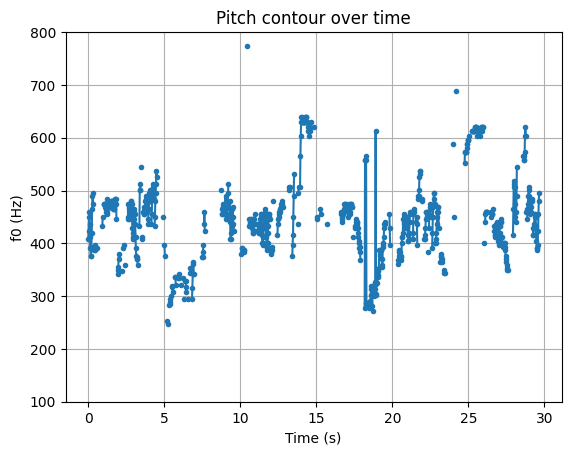

In [17]:
audio1 = 'pansoori_female.wav'
audio2 = 'violin-sanidha.wav'

input = audio1

#get the sr
sr, input = wavfile.read(input)

#run blocking
data, times = block_audio(input, sr=sr, frame_size=2048, hop_ratio=0.5, pad=True)

#apply auto correlation
f0s = [estimate_f0(frame, sr, 100, 800, threshold = 0.9) for frame in data]
f0s = np.array(f0s, dtype=np.float64)


#plot the contour
plt.plot(times, f0s, marker='.')
plt.xlabel("Time (s)")
plt.ylabel("f0 (Hz)")
plt.title("Pitch contour over time")
plt.ylim(100, 800)  # focus on expected pitch range
plt.grid(True)
plt.show()
